In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import os
import sys

import mlflow
import numpy as np
import scanpy as sc
import squidpy as sq

from autotalker.data import load_spatial_adata_from_csv
from autotalker.models import Autotalker
from autotalker.utils import download_nichenet_ligand_target_mx
from autotalker.utils import extract_gps_from_ligand_target_mx
from autotalker.utils import add_binary_gp_mask_to_adata
from autotalker.utils import extract_gps_from_omnipath_lr_interactions

In [3]:
dataset = "squidpy_seqfish"

In [4]:
print(f"Using dataset {dataset}.")

if dataset == "deeplinc_seqfish":
    adata = load_spatial_adata_from_csv("datasets/seqFISH/counts.csv",
                                        "datasets/seqFISH/adj.csv")
    cell_type_key = None
elif dataset == "squidpy_seqfish":
    adata = sq.datasets.seqfish()
    sq.gr.spatial_neighbors(adata, radius = 0.04, coord_type="generic")
    cell_type_key = "celltype_mapped_refined"
elif dataset == "squidpy_slideseqv2":
    adata = sq.datasets.slideseqv2()
    sq.gr.spatial_neighbors(adata, radius = 30.0, coord_type="generic")
    cell_type_key = "cluster"

Using dataset squidpy_seqfish.


In [5]:
print(f"Number of nodes: {adata.X.shape[0]}")
print(f"Number of node features: {adata.X.shape[1]}")
avg_edges_per_node = round(
    adata.obsp['spatial_connectivities'].toarray().sum(axis=0).mean(),2)
print(f"Average number of edges per node: {avg_edges_per_node}")
n_edges = int(np.triu(adata.obsp['spatial_connectivities'].toarray()).sum())
print(f"Number of edges: {n_edges}", sep="")

Number of nodes: 19416
Number of node features: 351
Average number of edges per node: 4.4
Number of edges: 42694


In [6]:
os.makedirs("mlruns", exist_ok=True)

In [7]:
experiment = mlflow.set_experiment("autotalker")
mlflow.log_param("dataset", dataset)

In [33]:
node_label_method = "one-hop"
n_latent = 32

# Mask that allows all genes
if node_label_method == "self":
    n_output = len(adata.var)
elif node_label_method == "one-hop":
    n_output = len(adata.var) * 2
    
mask = np.ones((n_latent, n_output))
print(mask.shape)

(32, 702)


In [49]:
model = Autotalker(adata,
                   adj_key="awa",
                   gp_mask_key="autotalker_gp_mask",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   node_label_method="one-hop",
                   n_hidden_encoder=32,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_mask=mask)

--- INITIALIZING NEW NETWORK MODULE: VGPGAE ---
GCN ENCODER -> n_input: 351, n_hidden: 32, n_latent: 32, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 32, n_output: 702


In [50]:
model.train(n_epochs=20,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            node_test_ratio=0.0,
            edge_batch_size=64,
            mlflow_experiment_id=experiment.experiment_id)

--- INITIALIZING TRAINER ---


KeyError: 'awa'

In [27]:
model.save(dir_path="./model_artefacts",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

In [28]:
model = Autotalker.load(dir_path="./model_artefacts",
                        adata=None,
                        adata_file_name="adata.h5ad")

--- INITIALIZING NEW NETWORK MODULE: VGPGAE ---
GCN ENCODER -> n_input: 351, n_hidden: 32, n_latent: 16, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 16, n_output: 702


In [41]:
latent = model.get_latent_representation()

In [42]:
latent_new_data = model.get_latent_representation(adata)

In [43]:
adata.obsm["latent_autotalker"] = latent_new_data

## Interoperability with scanpy

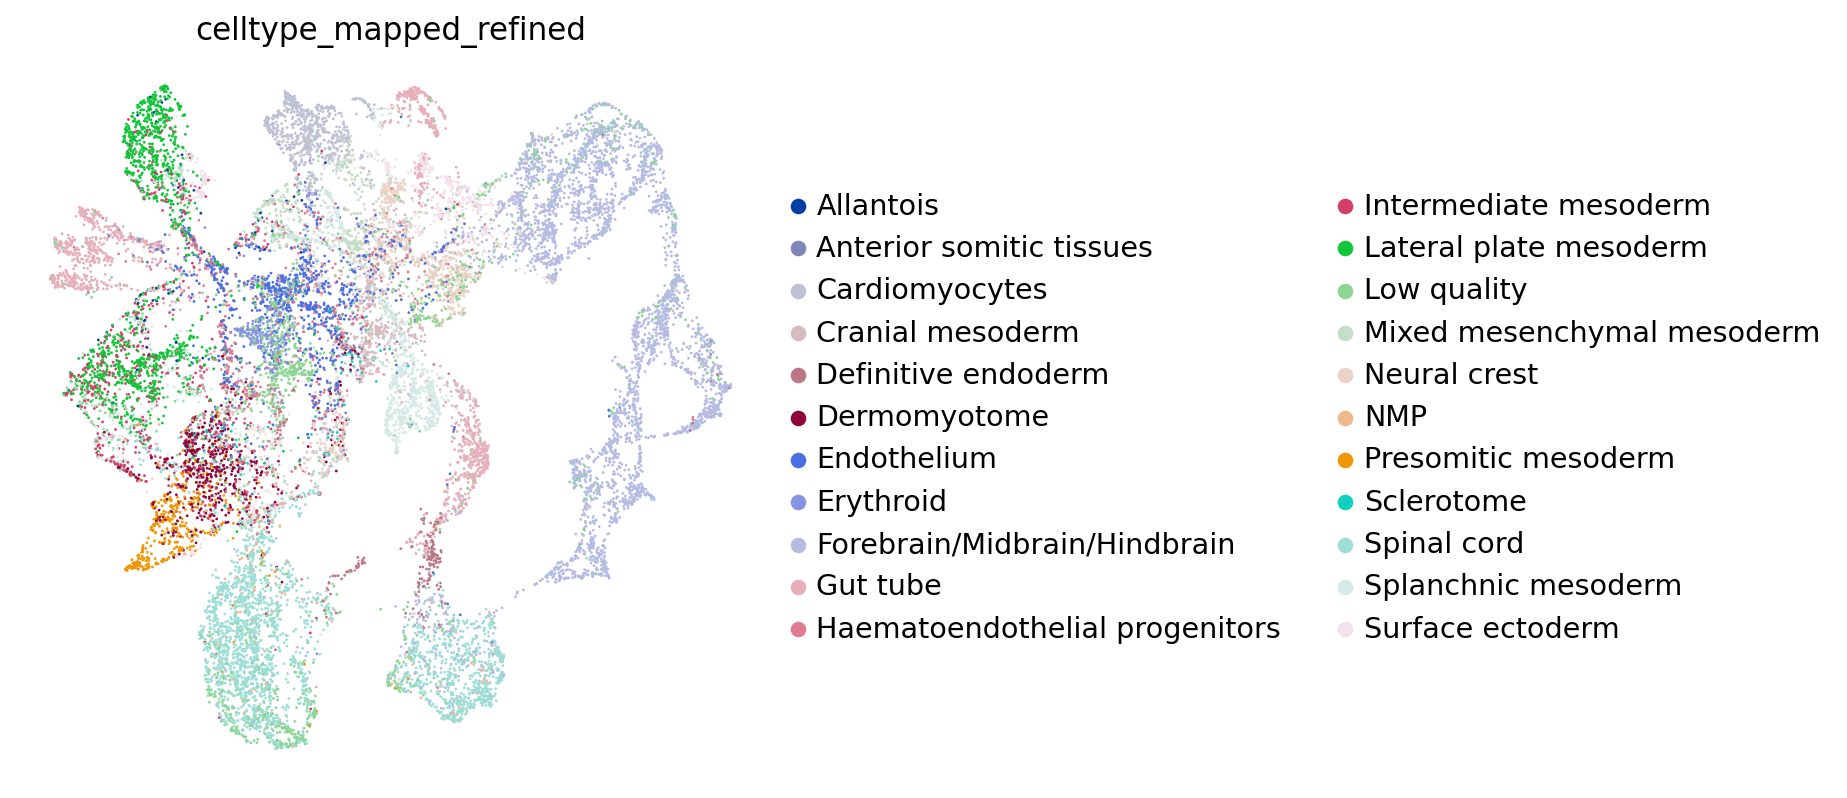

In [44]:
sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save="_latent.png")

## Gene Programs (GPs)

### NicheNet

In [ ]:
gp_data_folder_path = "datasets/gp_data"
gp_data_file_path = gp_data_folder_path + "/ligand_target_matrix.csv"
os.makedirs(gp_data_folder_path, exist_ok=True)

In [ ]:
download_nichenet_ligand_target_mx(
    save_path=gp_data_file_path)

In [ ]:
gp_dict = extract_gps_from_ligand_target_mx(
    path=gp_data_file_path)

In [ ]:
add_binary_gp_mask_to_adata(adata=adata,
                            gp_dict=gp_dict)

### OmniPath

In [ ]:
lr_interactions = retrieve_omnipath_lr_interactions()

In [ ]:
lr_gp_dict = extract_gps_from_omnipath_lr_interactions()

In [ ]:
lr_gp_dict

In [ ]:
lr_interactions = retrieve_omnipath_lr_interactions()

In [ ]:
lr_interactions

In [ ]:
experiment = mlflow.set_experiment("autotalker_gp_masked")
mlflow.log_param("dataset", dataset)

In [ ]:
gp_mask = adata.varm["autotalker_gps"].T
print(f"Gene program mask shape (gene programs x nodes): {gp_mask.shape}")
n_hidden_encoder = int(gp_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {n_hidden_encoder}")

In [ ]:
model = Autotalker(adata,
                   autotalker_module="VGPGAE",
                   n_hidden_encoder=n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_mask=gp_mask)

In [ ]:
model.train(n_epochs=20,
            lr=0.001,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            node_test_ratio=0.0,
            edge_batch_size=64,
            include_edge_recon_loss=True,
            include_gene_expr_recon_loss=True,
            mlflow_experiment_id=experiment.experiment_id)

The model can maintain the edge reconstruction performance while tweaking the latent space for better gene expression reconstruction.

In [ ]:
latent_gps = model.get_latent_representation()

In [ ]:
latent_gps_new_adata = model.get_latent_representation(adata)

In [ ]:
adata.obsm["latent_gps_autotalker"] = latent_gps_new_adata

In [ ]:
sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent gp space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_gps_autotalker")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False)

In [ ]:
gp_mask.shape

In [ ]:
gene_programs = adata.uns["gene_programs"]
selected_gene_programs = ["CSF1", "IL34"]
selected_gene_programs_idx = [gene_programs.index(gene_program) for gene_program in selected_gene_programs]

In [ ]:
latent_selected_gps = latent_gps[:, selected_gene_programs_idx]

In [ ]:
adata.obs["CSF1"] = latent_selected_gps[:, 0]
adata.obs["IL34"] = latent_selected_gps[:, 1]

In [ ]:
sc.pl.umap(adata, color="IL34", frameon=False, wspace=0.6)

In [ ]:
sc.pl.scatter(adata, x="CSF1", y="IL34", color=cell_type_key, size=10)

## SCVI

In [ ]:
import scvi
import scanpy as sc
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(6, 6))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [ ]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [ ]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts"
)

In [ ]:
model = scvi.model.SCVI(adata)

In [ ]:
model

In [ ]:
model.train()

In [ ]:
latent_scvi = model.get_latent_representation()

In [ ]:
adata.obsm["X_scVI"] = latent_scvi

In [ ]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

In [ ]:
sc.pl.umap(adata, color=["celltype_mapped_refined"], frameon=False,)